In [ ]:
# Import Libraries

import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from torchvision.models import AlexNet_Weights
from torch.utils.data import DataLoader, random_split

from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

from torch.optim import lr_scheduler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Specify the path to the locally saved dataset
train_data_dir = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset'
train_dataset = datasets.ImageFolder(train_data_dir)

In [ ]:
# Preprocessing steps used for imagenet dataset with the original AlexNet model
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# preprocessed dataset
preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

# DataLoader for the dataset
data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [ ]:
# Paths for each class
MildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

# Printing the MRI counts
print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8960

Total MRIs in the dataset = 33984


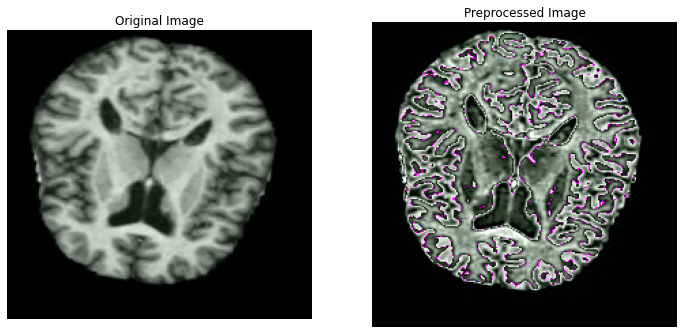

In [ ]:
# Sample MRI before and after preprocessing

sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

In [ ]:
# Dataset splitting

train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [ ]:
# custom model inspired by the AlexNet architecture

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, x):
        return self.leakyrelu(self.bn(self.conv(x)))

class CustomAlexNet2(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomAlexNet2, self).__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 64, kernel_size=11, stride=4, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ConvBlock(64, 192, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ConvBlock(192, 256, kernel_size=3, padding=1),
            ConvBlock(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        output_size = 256 * 6 * 6

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(output_size, 4096),
            nn.LeakyReLU(0.01),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.01),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the modified CustomAlexNet model
model2 = CustomAlexNet2(num_classes=4)

In [ ]:
summary(model2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
       BatchNorm2d-2           [-1, 64, 55, 55]             128
         LeakyReLU-3           [-1, 64, 55, 55]               0
         ConvBlock-4           [-1, 64, 55, 55]               0
         MaxPool2d-5           [-1, 64, 27, 27]               0
            Conv2d-6          [-1, 192, 27, 27]         307,392
       BatchNorm2d-7          [-1, 192, 27, 27]             384
         LeakyReLU-8          [-1, 192, 27, 27]               0
         ConvBlock-9          [-1, 192, 27, 27]               0
        MaxPool2d-10          [-1, 192, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         442,624
      BatchNorm2d-12          [-1, 256, 13, 13]             512
        LeakyReLU-13          [-1, 256, 13, 13]               0
        ConvBlock-14          [-1, 256,

In [ ]:
print(model2)

CustomAlexNet2(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (conv): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    

In [ ]:
# code to train and evaluate the Custom AlexNet model from scratch (without the pre-trained weights)

model2 = CustomAlexNet2(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_epoch(epoch_index, train_loader, model, optimizer):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model2.train()  # Set model to training mode
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model2.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model2(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5  # Early stopping patience
trigger_times = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model2, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model2)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Store losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

Epoch 1 [train] Progress:   1%|▋                                                                                   | 6/744 [00:46<1:34:21,  7.67s/batch]


KeyboardInterrupt: 

In [ ]:
# classification report (val loader)
loaded_model = CustomAlexNet2(num_classes=4).to(device)

loaded_model.load_state_dict(torch.load('AlexNet_26.pth'))

def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(loaded_model, val_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(loaded_model, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

In [ ]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, val_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, loaded_model, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

In [ ]:
model_save_path = '/Users/savin/Desktop/FYP/Implementation'
os.makedirs(model_save_path, exist_ok=True)
model_save_file = os.path.join(model_save_path, 'AlexNet_26.pth')

torch.save(loaded_model.state_dict(), model_save_file)

print(f'Model saved to {model_save_file}')